In [5]:
import torch
import numpy as np
from botorch.models import SingleTaskGP
from botorch.test_functions import Ackley,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,DixonPrice,Levy,StyblinskiTang,Griewank
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize,normalize
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt

In [6]:
from model import DerivativeExactGPSEModel
from acquisition import (MES_KnownOptimum,TruncatedExpectedImprovement,ExpectedImprovement,Fstar_pdf,
                            Fstar_pdf_GradientEnhanced,Fstar_pdf_GradientEnhanced_fantasy)
from acquisition import  My_acquisition_opt

ImportError: cannot import name 'Fstar_pdf_GradientEnhanced_fantasy' from 'acquisition' (/home/hanyang/Documents/Graident_based_method/acquisition.py)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

torch.set_default_dtype(dtype)

In [11]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

In [12]:
N = 12
iter_num = 50

function = StyblinskiTang(dim=4,negate=True)
fstar= 4*39.16599

bounds=function.bounds.to(device)
dim = bounds.shape[1]

standard_bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T.to(device)

# My acquisition optimization

# EI

In [42]:
EI_record = []

for exp in range(N):

  print(exp)
  torch.manual_seed(exp)

  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (iter_num):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)    

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    torch.manual_seed(exp+iter_num)
    try:
        fit_gpytorch_mll(mll)
    except:
        pass
            
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    AF = ExpectedImprovement(model=model, best_f=train_obj_standard.max().item()) .to(device)

    # new_point_analytic, _ = optimize_acqf(
    #     acq_function=AF,
    #     bounds=standard_bounds .to(device),
    #     q=1,
    #     num_restarts=3*dim,
    #     raw_samples=30*dim,
    #     options={},
    # )
    
    new_point_analytic = My_acquisition_opt(AF,dim)
    new_point_analytic = torch.tensor(new_point_analytic).reshape(-1,dim)
    
    
    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)


    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  EI_record.append(best_value_holder)

0
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-29.49338439114822
-29.49338439114822
-29.49338439114822
-29.49338439114822
-29.49338439114822
-29.49338439114822
-4.309600091884611
-4.309600091884611
-4.309600091884611
-4.309600091884611
-4.309600091884611
-4.309600091884611
-4.309600091884611
-3.3198263115046562
-3.3198263115046562
-3.3198263115046562
1
-1035.570816361854
-1035.570816361854
-1035

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-45.53631580781091
-45.53631580781091
-38.923011124325356
-38.923011124325356
-38.923011124325356


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-38.923011124325356
2
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-414.9695014035169
-155.06961373175827
-155.06961373175827
-155.06961373175827
-155.06961373175827
-155.06961373175827


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-155.06961373175827
-155.06961373175827
-155.06961373175827
-155.06961373175827
-12.337332108757852
-12.337332108757852
-12.337332108757852
-12.337332108757852
-4.582306626082126
-4.582306626082126
-4.582306626082126
-4.582306626082126
-4.582306626082126
3
-1879.8135351534747
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14.270661765055433
-14

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-10.304957822448003
-10.304957822448003
-10.304957822448003
5
-2251.115734863208
-2251.115734863208
-2251.115734863208
-2251.115734863208
-2251.115734863208
-2251.115734863208
-2251.115734863208
-2251.115734863208
-2251.115734863208
-1470.7378027555812
-1470.7378027555812
-1470.7378027555812
-743.5790002583705
-743.5790002583705
-743.5790002583705
-743.5790002583705
-743.5790002583705
-743.5790002583705
-743.5790002583705
-743.5790002583705
-743.5790002583705
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-106.59348201047727
-85.41924192597618
-85.41924192597618


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-85.41924192597618
-85.41924192597618
-30.249672464514177


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-30.249672464514177


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-30.249672464514177
6
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-48.25218195245871
-48.25218195245871
-48.25218195245871
-48.25218195245871


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-48.25218195245871
-48.25218195245871


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-48.25218195245871


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-48.25218195245871
7
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639
-19.32811394310639


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-19.32811394310639
-19.32811394310639
8
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-736.9444005459234
-467.6455124363763
-467.6455124363763
-175.7642513669526
-175.7642513669526
-175.7642513669526
-175.7642513669526
-175.7642513669526
-175.7642513669526
-144.85645345452596
-144.85645345452596
-2.179325693135085
-2.179325693135085
-2.179325693135085
-2.179325693135085
-2.179325693135085
9
-767.0

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-35.030107910487374
-35.030107910487374
-35.030107910487374
-22.752057884519157
-22.752057884519157
-13.340697279689978
10
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-509.79898717077765
-332.74080744898725
-332.74080744898725
-332.74080744898725
-332.74080744898725
-332.74080744898725
-332.74080744898725
-332.74080744898725
-332.74080744898725
-73.44800577561527
-73.44800577561527
-13.413887152748126
-13.413887152748126
-13.413887152748126
-13.413887152748126
-13.413887152748126
-13.413887152748126
-13.413887152748126

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-22.106028827625515
-11.424575473448048


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-11.424575473448048


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-11.424575473448048


# TEI

In [44]:
TEI_record = []

for exp in range(N):

  print(exp)
  torch.manual_seed(exp)


  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (iter_num):


    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()
    fstar_standard = (fstar - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)
    #model = SingleTaskGP(train_x_standard, train_obj_standard).to(device)
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
        fit_gpytorch_mll(mll)
    except:
        pass
            
    
    
    torch.manual_seed(exp+iter_num)
    AF = TruncatedExpectedImprovement(model=model, best_f=train_obj_standard.max().item(),fstar=fstar_standard) .to(device)
    
    # new_point_analytic, _ = optimize_acqf(
    #     acq_function=AF,
    #     bounds=standard_bounds .to(device),
    #     q=1,
    #     num_restarts=5*dim,
    #     raw_samples=30*dim,
    #     options={},
    # )
    
    new_point_analytic = My_acquisition_opt(AF,dim)
    new_point_analytic = torch.tensor(new_point_analytic).reshape(-1,dim)



    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)


    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  TEI_record.append(best_value_holder)

0
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-51.861432107677835
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-27.481159583673325
-26.950989798936213
-19.798799874997556
-19.798799874997556
-19.798799874997556
-19.798799874997556
-19.798799874997556
-19.798799874997556
-19.798799874997556
-19.798799874997556
-15.72751869717924
-15.72751869717924
-15.72751869717924
-15.72751869717924
1
-2564

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-28.899895651049523
-28.899895651049523
2
-414.9695014035169
-414.9695014035169
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-243.26882557451478
-218.57487914482374
-218.57487914482374
-218.57487914482374
-218.57487914482374
-218.57487914482374
-218.57487914482374
-197.43091933471942
-197.43091933471942
-197.43091933471942
-197.43091933471942
-197.43091933471942
-197.43091933471942
-170.76378028040082
-170.76378028040082
-170.76378028040082
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-167.93719163912104
-153.40099136345563
-153.40099136345563
-153.40099136345563
-153.40099136345563
-153.40099136345563
-153.40099136345563


/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-25.042056348017624
-25.042056348017624
-25.042056348017624
-15.930409669676672
-15.930409669676672
-15.930409669676672
10
-311.4181532047062
-311.4181532047062
-311.4181532047062
-60.31224549074132
-60.31224549074132
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32.07180048148151
-32

# MES

In [46]:
MES_record = []

for exp in range(N):

  print(exp)
  torch.manual_seed(exp)

  #train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)


  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (iter_num):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()
    fstar_standard = (fstar - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)

    #model = SingleTaskGP(train_x_standard, train_obj_standard).to(device)
    

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
        fit_gpytorch_mll(mll)
    except:
        pass
            
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    AF = MES_KnownOptimum(model=model, fstar=fstar_standard) .to(device)

    # new_point_analytic, _ = optimize_acqf(
    #     acq_function=AF,
    #     bounds=standard_bounds .to(device),
    #     q=1,
    #     num_restarts=3*dim,
    #     raw_samples=30*dim,
    #     options={},
    # )
    
    new_point_analytic = My_acquisition_opt(AF,dim)
    new_point_analytic = torch.tensor(new_point_analytic).reshape(-1,dim)


    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)


    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  MES_record.append(best_value_holder)

0
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-82.92461095567838
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-26.80909041131834
-24.23530121285434
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-24.134841715183267
-19.45424653892527
-19.45424653892527
-19.45424653892527
-9.633733648352493
-9.633733648352493
-9.633733648352493
-9.633733648352493
-9.633733648352493
-9.633733648352493
-9.633733648352493
-9.633733648352493
-9.633733648352493
1
-2306.1898630953538
-2306.189863095

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimi

-28.08732479234319
-28.08732479234319
11
-1436.9286040217505
-1436.9286040217505
-1436.9286040217505
-1436.9286040217505
-1436.9286040217505
-373.41932443684385
-373.41932443684385
-373.41932443684385
-373.41932443684385
-373.41932443684385
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-142.4871462501447
-65.28199365858941
-65.28199365858941
-41.50468562609554
-41.50468562609554
-41.50468562609554
-37.345012391764676
-37.045416953317996
-37.045416953317996
-36.31345371978583
-36.31345371978583
-36.31345371978583
-34.03020428996524
-34.03020428996524
-34.03020428996524
-34.03020428996524
-23.319867521799114
-23.319867521799114
-22.727262248770163
-22.727262248770163
-22.727262248770163
-22.727262248770163
-22.727262248770163
-22.727262248770163
-22.727262248770163
-22.727262248770163
-20.617659820896403
-20.617659820896403
-20

# Fstar_pdf

In [22]:
Fstar_pdf_record = []

for exp in range(8):

  print(exp)
  torch.manual_seed(exp)

  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (iter_num):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()
    fstar_standard = (fstar - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
      fit_gpytorch_mll(mll)
    except:
      pass
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    AF = Fstar_pdf(model=model, fstar=fstar_standard) .to(device)

    # new_point_analytic, _ = optimize_acqf(
    #     acq_function=AF,
    #     bounds=standard_bounds .to(device),
    #     q=1,
    #     num_restarts=3*dim,
    #     raw_samples=30*dim,
    #     options={},
    # )

    # print('new_point_analytic: ',new_point_analytic)
    np.random.seed(exp+i)
    new_point_analytic = My_acquisition_opt(AF,dim)
    new_point_analytic = torch.tensor(new_point_analytic).reshape(-1,dim)
    
    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)


    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  Fstar_pdf_record.append(best_value_holder)

0
112.48920313643954
112.48920313643954
115.11956622443222
116.8815138135369
116.8815138135369
116.8815138135369
127.9292668072376
127.9292668072376
127.9292668072376
127.9292668072376
128.5368084220454
128.5368084220454
128.5368084220454
128.5368084220454
128.5368084220454
128.5368084220454
128.5368084220454
128.5368084220454
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
141.9539740798306
151.40007816312405
1
107.72788954211318
107.72788954211318
107.72788954211318
120.5219260612071
137.4087257522108

# Pdf Gradient enhanced

In [17]:
Fstar_pdf_gradient_record = []

for exp in range(N):

  print(exp)
  torch.manual_seed(exp)

  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (iter_num):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()
    fstar_standard = (fstar - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
      fit_gpytorch_mll(mll)
    except:
      pass
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    AF = Fstar_pdf_GradientEnhanced(model=model, fstar=fstar_standard) .to(device)

    # new_point_analytic, af_val = optimize_acqf(
    #     acq_function=AF,
    #     bounds=standard_bounds .to(device),
    #     q=1,
    #     num_restarts=3*dim,
    #     raw_samples=30*dim,
    #     options={},
    # )

    
    # print('new_point_analytic: ',new_point_analytic)
    # print('AF value: ',af_val)
    np.random.seed(exp+i)
    new_point_analytic = My_acquisition_opt(AF,dim)
    new_point_analytic = torch.tensor(new_point_analytic).reshape(-1,dim)
    
    print('new_point_analytic: ',new_point_analytic)

    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)

    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  Fstar_pdf_gradient_record.append(best_value_holder)

0
new_point_analytic:  tensor([[0.3102, 0.6230, 0.1205, 0.6636]])
112.48920313643954
new_point_analytic:  tensor([[0.2842, 0.7920, 0.0763, 0.8267]])
112.48920313643954
new_point_analytic:  tensor([[0.1505, 0.7481, 0.1268, 0.7029]])
112.48920313643954
new_point_analytic:  tensor([[0.5646, 0.2647, 0.2520, 0.2723]])
112.48920313643954
new_point_analytic:  tensor([[0.5705, 0.1668, 0.3676, 0.2029]])
112.48920313643954
new_point_analytic:  tensor([[0.6245, 0.2862, 0.2277, 0.1206]])
112.48920313643954
new_point_analytic:  tensor([[0.2607, 0.7459, 0.2542, 0.7643]])
120.44732891559738
new_point_analytic:  tensor([[0.7000, 0.0317, 0.1282, 0.1632]])
120.44732891559738
new_point_analytic:  tensor([[0.6689, 0.3302, 0.5043, 0.0000]])
120.44732891559738
new_point_analytic:  tensor([[0.7093, 0.2416, 0.2901, 0.2318]])
126.96687421462867
new_point_analytic:  tensor([[0.8630, 0.0968, 0.4421, 0.2703]])
126.96687421462867
new_point_analytic:  tensor([[0.9413, 0.3216, 0.1957, 0.1094]])
126.96687421462867
ne

KeyboardInterrupt: 

In [38]:
model.likelihood.noise

tensor([6.1426e-06], grad_fn=<AddBackward0>)

# Pdf Gradient enhanced fantasy

In [ ]:
Fstar_pdf_gradient_record = []

for exp in range(N):

  print(exp)
  torch.manual_seed(exp)

  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (iter_num):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()
    fstar_standard = (fstar - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
      fit_gpytorch_mll(mll)
    except:
      pass
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    AF = Fstar_pdf_GradientEnhanced_fantasy(model=model, fstar=fstar_standard) .to(device)

    # new_point_analytic, af_val = optimize_acqf(
    #     acq_function=AF,
    #     bounds=standard_bounds .to(device),
    #     q=1,
    #     num_restarts=3*dim,
    #     raw_samples=30*dim,
    #     options={},
    # )

    
    # print('new_point_analytic: ',new_point_analytic)
    # print('AF value: ',af_val)
    np.random.seed(exp+i)
    new_point_analytic = My_acquisition_opt(AF,dim)
    new_point_analytic = torch.tensor(new_point_analytic).reshape(-1,dim)
    
    print('new_point_analytic: ',new_point_analytic)

    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)

    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  Fstar_pdf_gradient_record.append(best_value_holder)

# Plot

In [19]:
def log_RegretMean_plot(res,fstar,label,color,linestyle,error_bound=True):
    
    
    total_record = (fstar-np.array(res))
    
    
    N = total_record.shape[0]
    
    std = np.std(total_record,axis=0)
    
    mean = np.mean(total_record,axis=0)
    
    iter = np.array(range(mean.shape[0]))
    
    lower = mean - 1*std/np.sqrt(N)
    upper = mean + 1*std/np.sqrt(N)
    
    lower.astype(float)
    upper.astype(float)
    
    
    plt.plot(mean,linewidth=2,label=label,color=color,linestyle=linestyle)
    if error_bound:
        plt.fill_between(iter, lower, upper,alpha=0.25,color=color)   
    

Text(0.5, 1.0, 'Branin 2D')

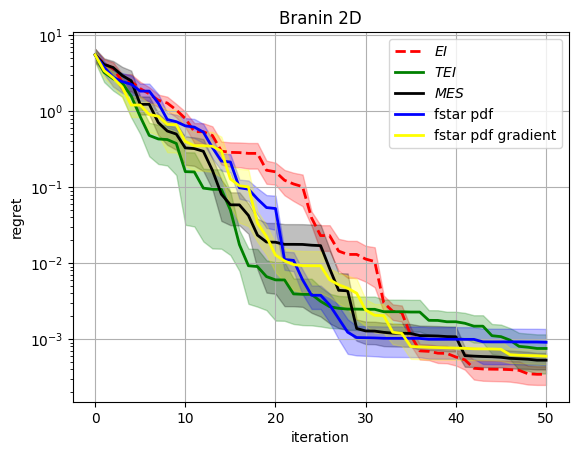

In [24]:
fstar = -0.397887

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Branin 2D')

Text(0.5, 1.0, 'SixHumpCamel 2D')

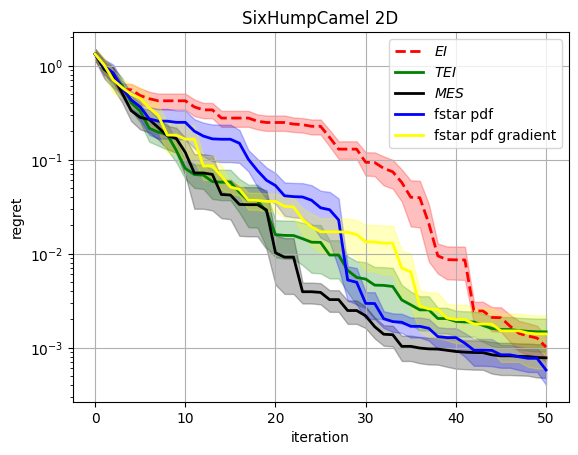

In [37]:
fstar = 1.0316

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('SixHumpCamel 2D')

Text(0.5, 1.0, 'Rosenbrock 3D')

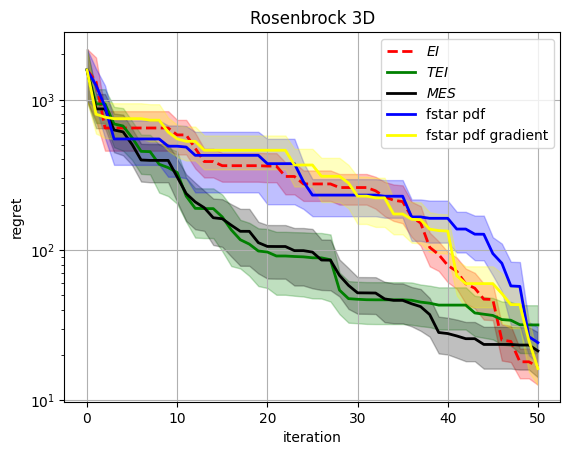

In [47]:
fstar = 0.

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Rosenbrock 3D')

Text(0.5, 1.0, 'Rosenbrock 3D')

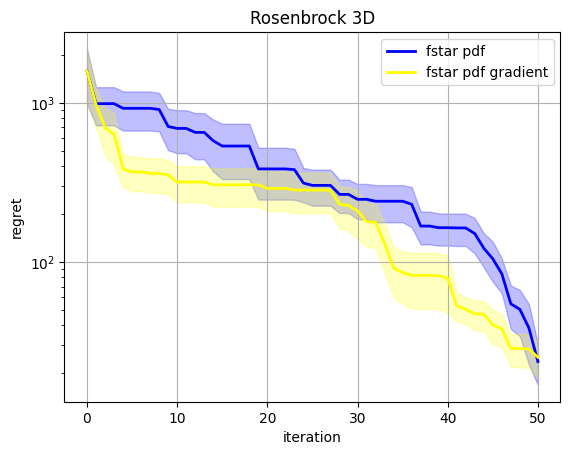

In [12]:
fstar = 0.

# log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
# log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Rosenbrock 3D')

Text(0.5, 1.0, 'Beale 2D')

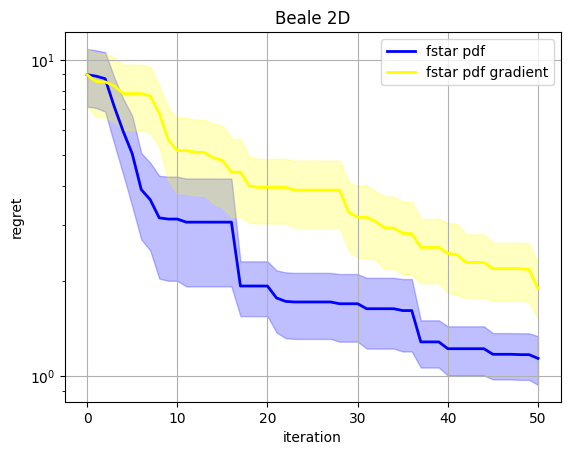

In [20]:
fstar = 0.

# log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
# log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Beale 2D')

Text(0.5, 1.0, 'SixHumpCamel 2D')

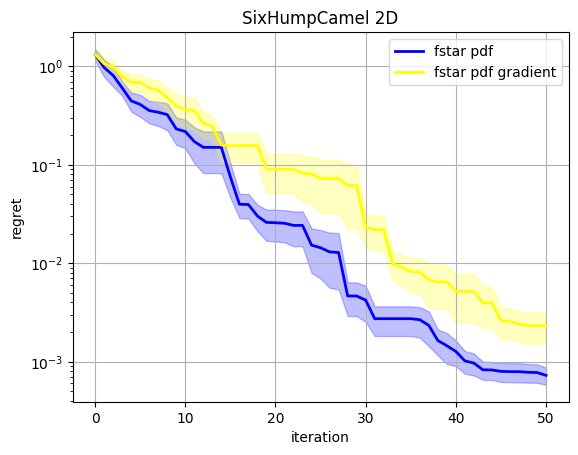

In [16]:
fstar = 1.0316

# log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
# log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('SixHumpCamel 2D')

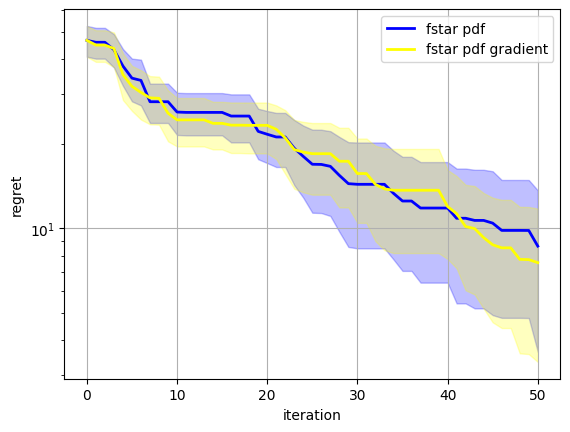

In [23]:
fstar = 4*39.16599

# log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
# log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
# plt.title('SixHumpCamel 2D')

In [21]:
len(Fstar_pdf_gradient_record)

8

Text(0.5, 1.0, 'Branin 2D')

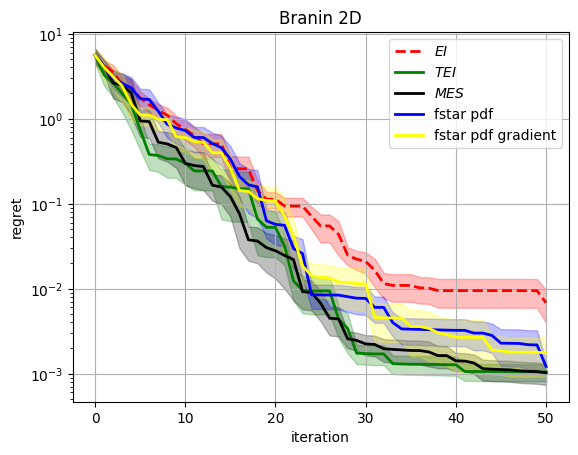

In [29]:
fstar = -0.397887

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Branin 2D')

Text(0.5, 1.0, 'Beale 2D')

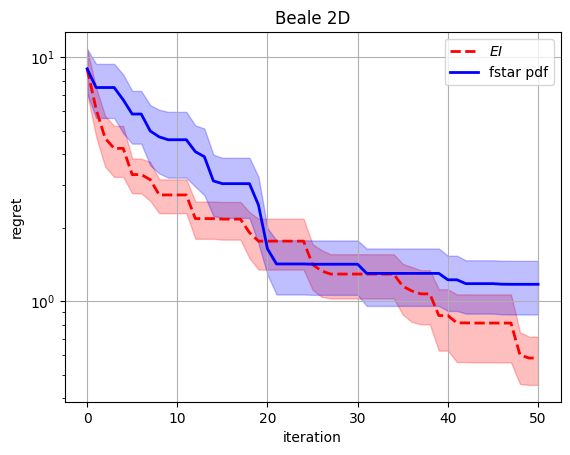

In [16]:
fstar = 0.

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
# log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='fstar pdf',color='blue',linestyle='-',error_bound=True)
# log_RegretMean_plot(np.array(Fstar_pdf_gradient_record),fstar=fstar,label='fstar pdf gradient',color='yellow',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Beale 2D')

Text(0.5, 1.0, 'Branin 2D')

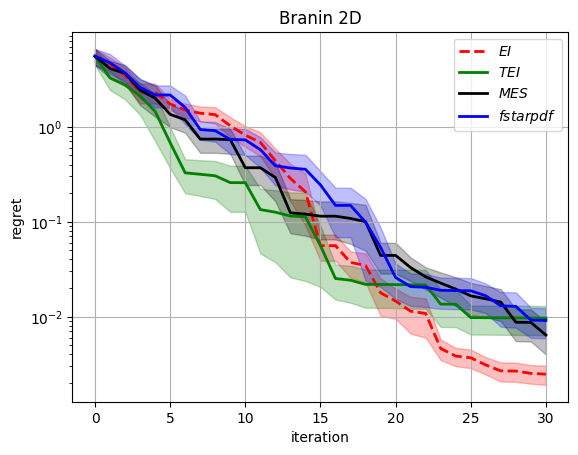

In [40]:
fstar = -0.397887

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='$fstar pdf$',color='blue',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('Branin 2D')

Text(0.5, 1.0, 'SixHumpCamel 2D')

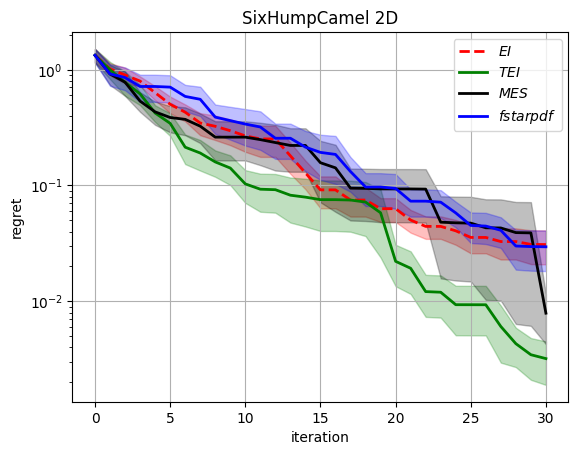

In [32]:
fstar = 1.0316

log_RegretMean_plot(np.array(EI_record),fstar=fstar,label='$EI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(np.array(TEI_record),fstar=fstar,label='$TEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(MES_record),fstar=fstar,label='$MES$',color='black',linestyle='-',error_bound=True)
log_RegretMean_plot(np.array(Fstar_pdf_record),fstar=fstar,label='$fstar pdf$',color='blue',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

#plt.grid()

plt.yscale("log") 
plt.grid()
plt.legend()
plt.title('SixHumpCamel 2D')

In [14]:
from botorch.utils.probability.utils import log_phi, log_ndtr,ndtr as Phi, phi

In [7]:
EI_record = []

for exp in range(1):

  print(exp)
  torch.manual_seed(exp)

  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (1):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)

    #model = SingleTaskGP(train_x_standard, train_obj_standard).to(device)
    

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    torch.manual_seed(exp+iter_num)
    fit_gpytorch_mll(mll)
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    AF = ExpectedImprovement_GradientEnhanced(model=model, best_f=train_obj_standard.max().item()) .to(device)

0


In [12]:
AF.model

DerivativeExactGPSEModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(1.000E-05, 2.000E-05)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [9]:
AF(torch.tensor([0.5,0.5]).reshape(-1,2))

RuntimeError: expected scalar type Float but found Double